In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import sklearn.manifold
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('./data/online-retail-data.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.dropna(inplace=True)

In [4]:
df['StockCode'] = df['StockCode'].astype(str)

In [5]:
customers = set(df['CustomerID'])
customers = list(customers)

In [6]:
customers_train = random.sample(customers, (round(len(customers)*.9)))
print(len(customers_train))

3935


In [7]:
train_df = df[df['CustomerID'].isin(customers_train)]
test_df = df[~df['CustomerID'].isin(customers_train)]

In [8]:
# история покупок для обучающей выборки
purchases_train = []
for i in tqdm(customers_train):
    in_training = train_df[train_df['CustomerID'] == i]['StockCode'].tolist()
    purchases_train.append(in_training)

100%|████████████████████████████████████████████████████████████████████████████| 3935/3935 [00:03<00:00, 1017.24it/s]


In [9]:
# история покупок для обучающей тестовой выборки
purchases_test = []

for i in tqdm(test_df['CustomerID'].unique()):
    in_training = test_df[test_df['CustomerID'] == i]['StockCode'].tolist()
    purchases_test.append(in_training)

100%|██████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 1710.18it/s]


На данном этапе мы создали 2 матрицы покупок:
1. Матрица покупок purchases_train. состоит из списков кодов товара купленных пользователями. Каждый список это отдельный пользователь
2. Такая же матрица только для теста

### Модель W2V рассматривает каждый список покупок как предложение, а общий список как целый текст. Соответственно товары в нем это слова. Векторное представление строится на основании близости слов, т.е. частое появление вместе имеют схожий вектор. 

In [10]:
#  W2V


model = Word2Vec(window=10, sg=1, hs=0, negative=10, alpha=0.03, min_alpha=0.0007, seed=4)

#window - сколько слов слева справа рассматривается. 10 до и 10 после
#sg - Использование skip-gram архитектуры (1) или CBOW (0).
#hs - Использование иерархического софтмакса (1) или нет (0)
#negative - Количество "отрицательных" примеров для обучения
#alpha - Начальный learning rate (скорость обучения)
#min_alpha - Минимальный learning rate; alpha будет линейно уменьшаться до min_alpha в течение обучения

model.build_vocab(purchases_train, progress_per=200)
# Создается словарь - где каждый артикул уникальное слово

#total_examples=model.corpus_count - размер корпуса данных (3925 списков)
#epochs=10 - обучение будет повторяться 10 раз по всему корпусу данных.
#report_delay=1 - устанавливает задержку в секундах между сообщениями о прогрессе обучения


model.train(purchases_train, total_examples=model.corpus_count, epochs=10, report_delay=1)

(3618129, 3655040)

In [11]:
products = train_df[["StockCode", "Description"]]
# удалим дубликаты в данных
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")
# cоздадим единый словарь
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [12]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)


def similar_products(v, n = 6):
    
    # извлечение наиболее похожих элементов
    ms = model.wv.similar_by_vector(v, topn= n+1)[1:]
    
    # имена и значения схожести
    new_ms = []
    for j in ms:
        
        pair = (j, products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms   

#### Есть пользователь 0 и его выбор "продуктовой корзины" purchases_test[0]
#### Считаем вектора каждого товара и потом усредняем этот вектор  aggregate_vectors
#### По полученному вектору находим товары близкие 

In [15]:
aggregate_vectors(purchases_test[0])

array([ 4.68225032e-02, -1.51548624e-01,  1.93101671e-02, -9.05902088e-02,
        2.29909167e-01, -7.18032718e-02,  8.72191712e-02,  8.59267116e-02,
        1.83949694e-01, -2.52417810e-02, -7.17926323e-02,  3.05274483e-02,
       -1.62151065e-02,  9.12574157e-02, -2.43934199e-01,  1.51672617e-01,
       -5.80344573e-02,  1.28244460e-01,  4.97722393e-03,  1.47871286e-01,
       -1.04606010e-01, -2.52442099e-02, -6.30083010e-02, -1.41252978e-02,
       -1.33414179e-01, -1.60189390e-01, -2.52595484e-01, -3.00701819e-02,
       -2.36842617e-01, -5.72816692e-02, -2.90264219e-01, -3.20502222e-01,
        2.53773212e-01, -2.02833131e-01, -3.46756168e-02,  4.16641951e-01,
       -5.17022498e-02,  2.35443050e-03, -7.02915564e-02,  1.15073500e-02,
       -5.60062286e-03,  1.90081984e-01,  1.95819810e-02, -1.71124190e-01,
       -1.98410526e-01,  1.25823706e-01, -6.61305385e-03,  1.06183842e-01,
       -9.34756547e-02, -6.53490573e-02,  8.92063603e-02, -1.57445297e-01,
       -5.32346778e-02,  

In [16]:
# это как бы подбор близких к тому что брал покупатель
similar_products(aggregate_vectors(purchases_test[0]))

[(('23245', 0.6802366375923157),
  'SET OF 3 REGENCY CAKE TINS',
  0.6802366375923157),
 (('23298', 0.6748281121253967), 'SPOTTY BUNTING', 0.6748281121253967),
 (('84879', 0.6672268509864807),
  'ASSORTED COLOUR BIRD ORNAMENT',
  0.6672268509864807),
 (('22960', 0.6630811095237732),
  'JAM MAKING SET WITH JARS',
  0.6630811095237732),
 (('47566', 0.6498655676841736), 'PARTY BUNTING', 0.6498655676841736),
 (('22720', 0.6484830379486084),
  'SET OF 3 CAKE TINS PANTRY DESIGN ',
  0.6484830379486084)]

In [84]:
# Можно просто посмотреть близкие к товару
similar_products(model.wv['82551'])

[(('82552', 0.9161361455917358), 'WASHROOM METAL SIGN', 0.9161361455917358),
 (('82567', 0.7276467084884644),
  'AIRLINE LOUNGE,METAL SIGN',
  0.7276467084884644),
 (('82583', 0.689204216003418), 'HOT BATHS METAL SIGN', 0.689204216003418),
 (('21164', 0.6407061219215393),
  'HOME SWEET HOME METAL SIGN ',
  0.6407061219215393),
 (('21910', 0.6323609948158264), 'WAY OUT METAL SIGN ', 0.6323609948158264),
 (('82580', 0.6294923424720764), 'BATHROOM METAL SIGN', 0.6294923424720764)]

### Визуализация объектов

In [22]:
count = 10000
word_vectors_matrix = np.ndarray(shape=(count, 100), dtype='float64')
word_list = []
i = 0
for word in model.wv.key_to_index.keys():
    word_vectors_matrix[i] = model.wv[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (10000, 100)


### Уменьшим размероность с помощью t-SNE (t-Distributed Stochastic Neighbor Embedding)  до 2

In [34]:
# Создание 2Д пространства для объектов

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

word_vectors_matrix_2d shape is  (10000, 2)


In [38]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)

<Axes: xlabel='x', ylabel='y'>

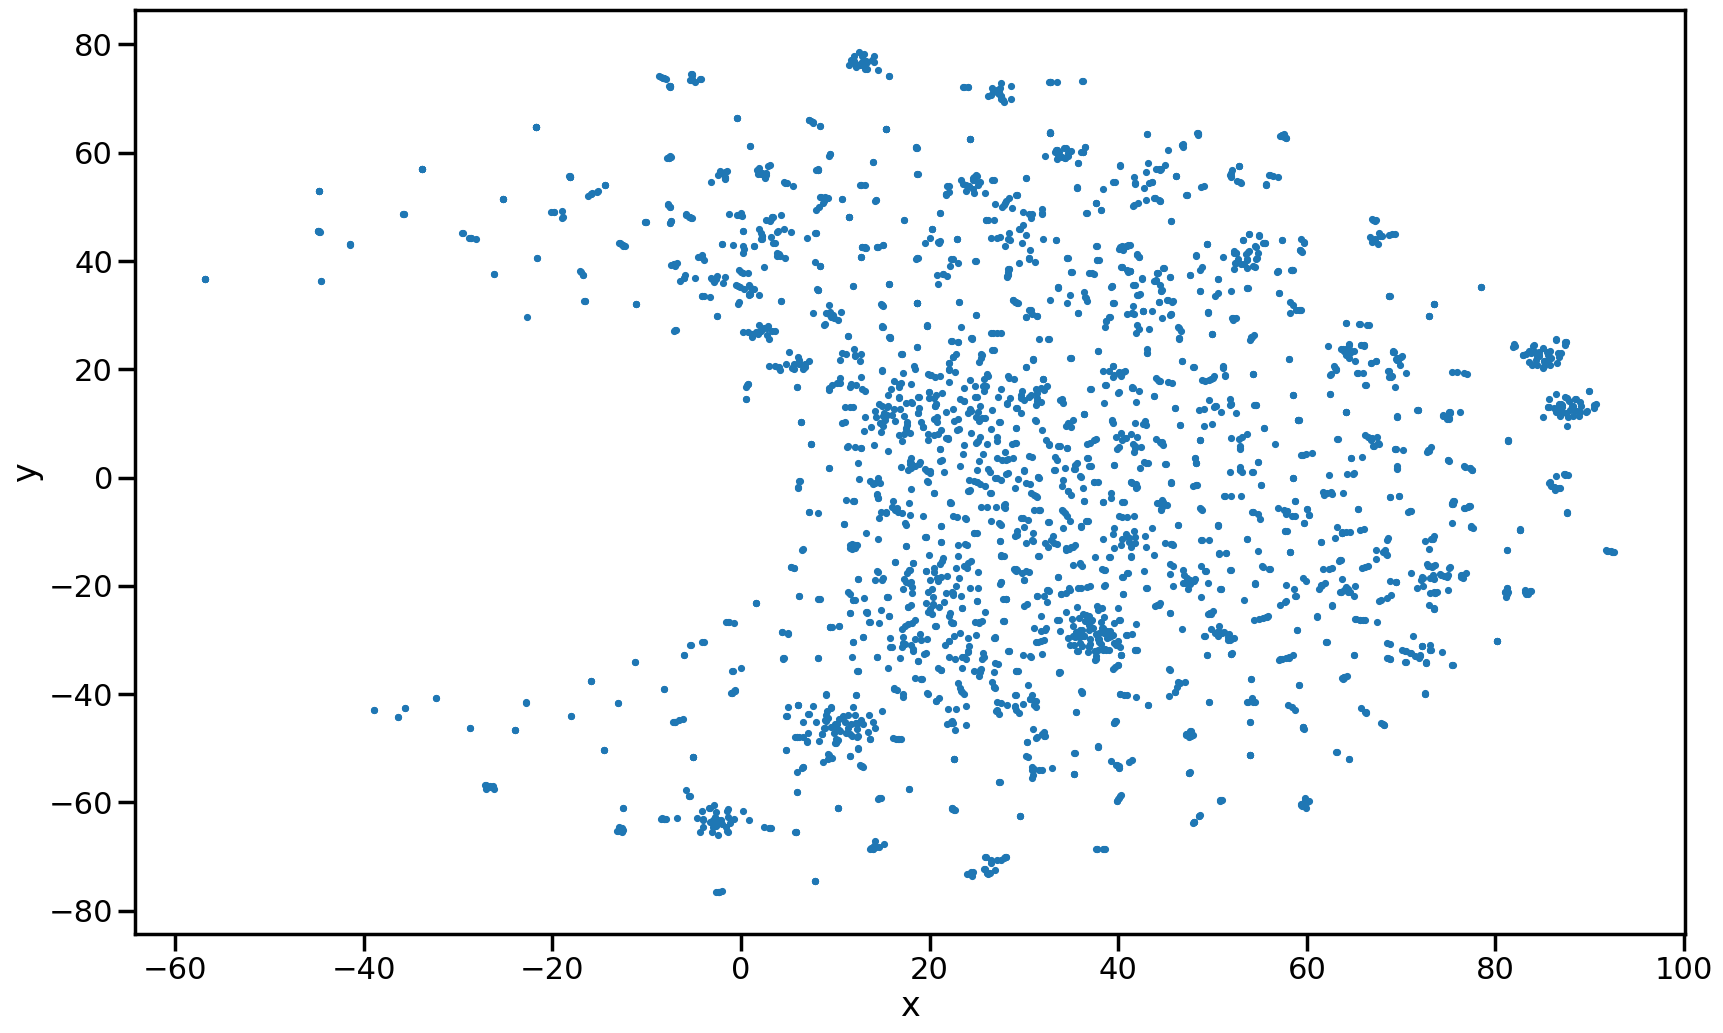

In [40]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

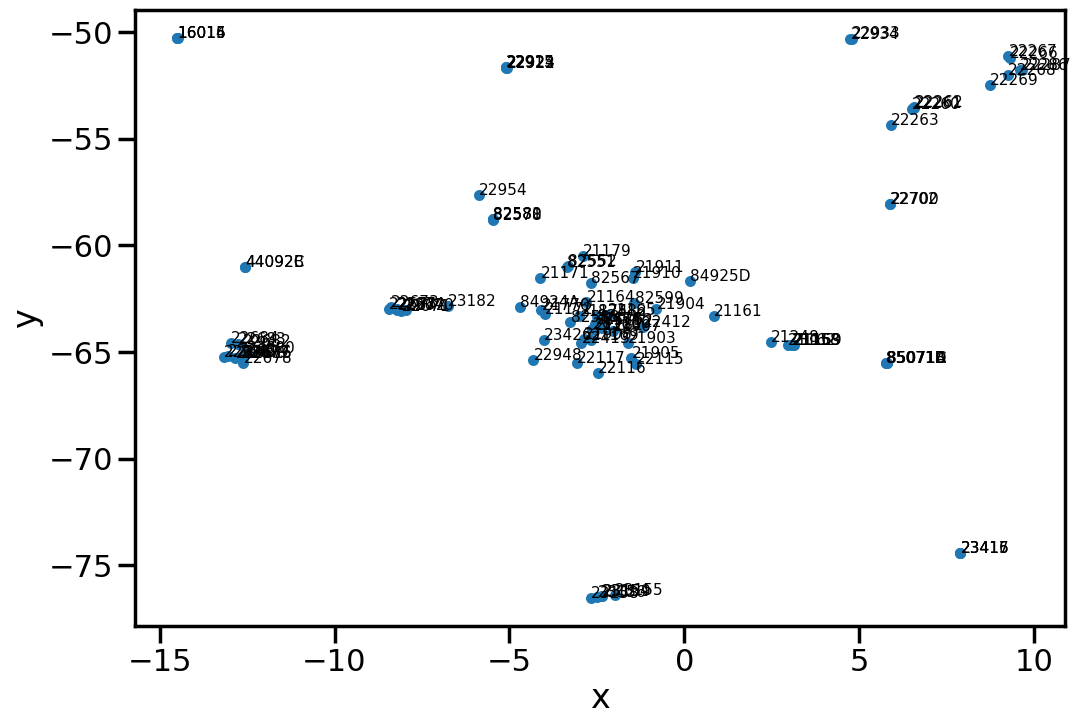

In [46]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) & (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) & (points.y <= y_bounds[1]) 
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(12, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
        
plot_region(x_bounds=(-20, 10), y_bounds=(-80, -50))

In [49]:
# Видно как товары кучкуются вместе
similar_products(model.wv['82551'])

[(('82552', 0.9161361455917358), 'WASHROOM METAL SIGN', 0.9161361455917358),
 (('82567', 0.7276467084884644),
  'AIRLINE LOUNGE,METAL SIGN',
  0.7276467084884644),
 (('82583', 0.689204216003418), 'HOT BATHS METAL SIGN', 0.689204216003418),
 (('21164', 0.6407061219215393),
  'HOME SWEET HOME METAL SIGN ',
  0.6407061219215393),
 (('21910', 0.6323609948158264), 'WAY OUT METAL SIGN ', 0.6323609948158264),
 (('82580', 0.6294923424720764), 'BATHROOM METAL SIGN', 0.6294923424720764)]

### Ещё вариант поиска схожести

In [83]:
# Напоминаю что это косинусное расстояние - в числителе скалярное произведение векторов (тоже что и sum(vec1*vec2)) 
# а в знаменателе евклидова норма векторов (т.е. их длина)

def cosine_distance(vec1, vec2):
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

In [51]:
#Берем один объект, получаем вектор (из модели), и находим расстояния по очереди с каждым вектором из всех продуктов
#Выбираем Топ схожих

def compute_similarity(model, topn=5, input_key=None, product_vec=None):
    all_similarities = []
    if not input_key and product_vec is None : return 0

    elif product_vec is None:
        product_vec = model.wv[input_key]
    
    for key, product_name in all_products.items():
        try:
            dist = cosine_distance(product_vec, model.wv[key])
            if dist != 1: all_similarities.append((product_name, dist))
        except:
            pass
        
    return sorted(all_similarities, key=lambda x: x[1], reverse=True)[:topn]

In [52]:
def seq_avg_vector(products):
    avg_vec = []
    for product in products:
        try:
            avg_vec.append(model.wv[product])
        except:
            pass
        
    return np.mean(avg_vec, axis=0)

In [54]:
def product_recommender(model, key, nb=3):
    print(f'Для продукта t "{all_products[key]}" созданы рекомендации :')
    recommendations = compute_similarity(model, input_key=key, topn=nb)
    for item in recommendations:
        print(f'\t - {item[0]}')

In [55]:
def sequence_recommender(model, orders_list, nb=3):
    print("Продукты покупаемые в последовательности :")
    for item in orders_list:
        print(all_products[item])
    
    print(f'\nБазируясь на истории покупок, можно создать последовательность рекомендаций :')
    recommendations = compute_similarity(model, product_vec=seq_avg_vector(orders_list), topn=nb)
    for item in recommendations:
        print(f'\t - {item[0]}')

In [57]:
all_products = df.groupby("StockCode")["Description"].unique().apply(lambda x: x[0]).to_dict()

In [58]:
product_recommender(model,'82551')

Для продукта t "LAUNDRY 15C METAL SIGN" созданы рекомендации :
	 - LAUNDRY 15C METAL SIGN
	 - WASHROOM METAL SIGN
	 - AIRLINE LOUNGE,METAL SIGN


In [65]:
sequence_recommender(model,['82551'])

Продукты покупаемые в последовательности :
LAUNDRY 15C METAL SIGN

Базируясь на истории покупок, можно создать последовательность рекомендаций :
	 - LAUNDRY 15C METAL SIGN
	 - WASHROOM METAL SIGN
	 - AIRLINE LOUNGE,METAL SIGN


array([6, 8])